# "Pump it Up: Data Mining the Water Table"

Data Understanding & Statistical Analysis

Jason & Tom

In [1]:
# Imports

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import string

# Data Understanding & Statistical Analysis

This notebook explains the steps we took to initially understand our data. We also produced some statistical analysis on each colum.

We both took different steps to do this, and collated our findings at the end. Cells by one author only will contain ``` Written By [Author] ``` at the top. Cells without this tag were steps taken by both of us, unless specified.

In [2]:
df_values = pd.read_csv('./datasets/train_features_water.csv')
df_labels = pd.read_csv('./datasets/train_labels_water.csv')
df = df_values.merge(df_labels, on='id', how='left')

In [3]:
df.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,...,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,functional
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,...,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional


## 1.0 Initial Understanding / Data Quality Assesment

In [5]:
df.shape

(59400, 41)

In [6]:
df.describe()

,id,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year
count,59400.000000,59400.000000,59400.000000,59400.000000,5.940000e+04,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000
mean,37115.131768,317.650385,668.297239,34.077427,-5.706033e+00,0.474141,15.297003,5.629747,179.909983,1300.652475
std,21453.128371,2997.574558,693.116350,6.567432,2.946019e+00,12.236230,17.587406,9.633649,471.482176,951.620547
min,0.000000,0.000000,-90.000000,0.000000,-1.164944e+01,0.000000,1.000000,0.000000,0.000000,0.000000
25%,18519.750000,0.000000,0.000000,33.090347,-8.540621e+00,0.000000,5.000000,2.000000,0.000000,0.000000
50%,37061.500000,0.000000,369.000000,34.908743,-5.021597e+00,0.000000,12.000000,3.000000,25.000000,1986.000000
75%,55656.500000,20.000000,1319.250000,37.178387,-3.326156e+00,0.000000,17.000000,5.000000,215.000000,2004.000000
max,74247.000000,350000.000000,2770.000000,40.345193,-2.000000e-08,1776.000000,99.000000,80.000000,30500.000000,2013.000000


Some notes on ```df.describe()```

amount_tsh (total vertical distance pump carries the water from source to tap (m))

    - max value of 350000 seems excessively high, we should look into that
    - especially when the max gps height is only 2770m (gps height is height of pump from sea-level).
   

population

    - why is min & 25% = 0, what does this mean - is this an error or is there actually no people in these areas

construction_year

    - a lot of 0 values, we will definitely need to impute this, perhaps based off waterpoint type/district rather than the mean (although we can try both).

In [11]:
# percent of data that has construction year 0

df.loc[df['construction_year'] == 0].shape[0] / df['construction_year'].shape[0] * 100

34.86363636363636

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59400 entries, 0 to 59399
Data columns (total 41 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     59400 non-null  int64  
 1   amount_tsh             59400 non-null  float64
 2   date_recorded          59400 non-null  object 
 3   funder                 55765 non-null  object 
 4   gps_height             59400 non-null  int64  
 5   installer              55745 non-null  object 
 6   longitude              59400 non-null  float64
 7   latitude               59400 non-null  float64
 8   wpt_name               59400 non-null  object 
 9   num_private            59400 non-null  int64  
 10  basin                  59400 non-null  object 
 11  subvillage             59029 non-null  object 
 12  region                 59400 non-null  object 
 13  region_code            59400 non-null  int64  
 14  district_code          59400 non-null  int64  
 15  lg

In [9]:
total_nulls = df.isnull().sum()
total_obs = df.shape[0]

null_p = total_nulls[total_nulls > 0] / total_obs * 100
total_nulls = total_nulls[total_nulls > 0]

pd.concat([total_nulls, null_p], axis=1, keys=['Total', 'Percentage']).sort_values(by='Total', ascending=False)

,Total,Percentage
scheme_name,28166,47.417508
scheme_management,3877,6.526936
installer,3655,6.153199
funder,3635,6.119529
public_meeting,3334,5.612795
permit,3056,5.144781
subvillage,371,0.624579


Some notes on missing data:

    - scheme_name has too many missing values to be useful, we should drop this column.
    - scheme_management - this is a useful column so we shouldn't drop it, we could either replace all missing values with 'Other', (as we will likely have to do that anyway)
    - installer - same as scheme_management
    - funder - same as scheme_management
    - public_meeting - more information needed
    - permit - more information needed
    - subvillage we can impute based off other geographical data, perhaps using clustering, or we can drop as there might be too many unique values.

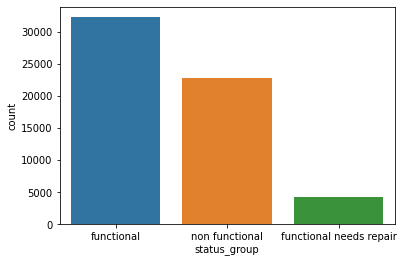

In [9]:
sns.countplot(data=df, x='status_group')
plt.show()

## 1.1 Checking Each Columns Values & Quality

**Unless specified, everything in section 1.1 was performed by Jason.**

### 1.1.1 Funder

In [14]:
df['funder'].value_counts()

Government Of Tanzania    9084
Danida                    3114
Hesawa                    2202
Rwssp                     1374
World Bank                1349
                          ... 
Rarymond Ekura               1
Justine Marwa                1
Municipal Council            1
Afdp                         1
Samlo                        1
Name: funder, Length: 1897, dtype: int64

In [15]:
df['funder'].isna().sum()

3635

In [16]:
len(df['funder'].unique())

1898

Observations :
- **777** rows contains 0's as their Funder.
- **3635** rows contain NaN values.
- **1898** Unique Elements including NaN.
- Spelling Mistakes are present for similar funder names. Exp: Zao Water Spring & Zao Water Spring X

Suggestions :
- This column might be not important for the modelling process and could be ignored.
- However, binning could be done to classify Funders as a group if required.

### 1.1.2 Installer

In [19]:
df['installer'].value_counts()

DWE                17402
Government          1825
RWE                 1206
Commu               1060
DANIDA              1050
                   ...  
Wizara  ya maji        1
TWESS                  1
Nasan workers          1
R                      1
SELEPTA                1
Name: installer, Length: 2145, dtype: int64

In [20]:
df['installer'].isna().sum()

3655

In [22]:
len(df['installer'].unique())

2146

Observations :
- **780** rows contain 0 or - as Installer.
- **3655** rows contain NaN values.
- **2146** Unique Elements including NaN.
- Spelling Mistakes are present for similar Installer names. Exp: Dr. Matomola, Dr.Matomola.

Suggestions :
- Spelling Mistakes would have to be corrected at the future if this column is important.
- Binning would have to be done to reduce num of unique instances.

### 1.1.3 Subvillage / Region

In [23]:
df['subvillage'].value_counts()

Madukani        508
Shuleni         506
Majengo         502
Kati            373
Mtakuja         262
               ... 
Kipompo           1
Chanyamilima      1
Ikalime           1
Kemagaka          1
Kikatanyemba      1
Name: subvillage, Length: 19287, dtype: int64

In [24]:
df['subvillage'].isna().sum()

371

In [26]:
len(df['subvillage'].unique())

19288

Observations :
- Has large number of subvillage's name.
- **371** rows containing NaN data.

Suggestions :
- Drop this column and use **Region** column instead as villages are assigned based on region.

### 1.1.4 Region

In [28]:
df['region'].value_counts()

Iringa           5294
Shinyanga        4982
Mbeya            4639
Kilimanjaro      4379
Morogoro         4006
Arusha           3350
Kagera           3316
Mwanza           3102
Kigoma           2816
Ruvuma           2640
Pwani            2635
Tanga            2547
Dodoma           2201
Singida          2093
Mara             1969
Tabora           1959
Rukwa            1808
Mtwara           1730
Manyara          1583
Lindi            1546
Dar es Salaam     805
Name: region, dtype: int64

In [29]:
df['region'].unique()

array(['Iringa', 'Mara', 'Manyara', 'Mtwara', 'Kagera', 'Tanga',
       'Shinyanga', 'Tabora', 'Pwani', 'Ruvuma', 'Kilimanjaro', 'Rukwa',
       'Mwanza', 'Kigoma', 'Lindi', 'Dodoma', 'Arusha', 'Mbeya',
       'Singida', 'Morogoro', 'Dar es Salaam'], dtype=object)

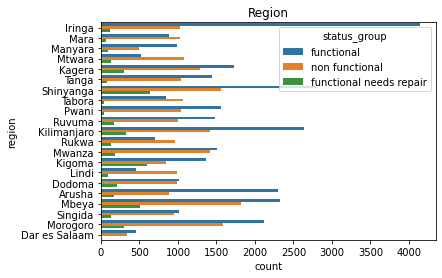

In [31]:
sns.countplot(data=df, y='region', hue='status_group', dodge=1.0)
plt.title('Region')
plt.show()

Observations :
- A region would have the same region code but can have different **district** code.
- Can drop **ward** and **lga** which could be represented by Region.

### 1.1.5 Public Meeting

In [33]:
df['public_meeting'].unique()

array([True, nan, False], dtype=object)

In [35]:
df['public_meeting'].isna().sum()

3334

In [36]:
df['public_meeting'].value_counts()

True     51011
False     5055
Name: public_meeting, dtype: int64

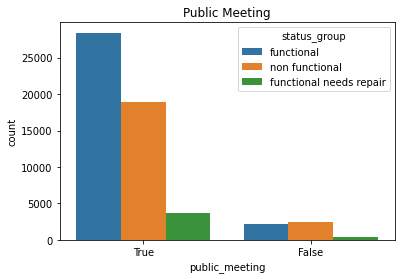

In [38]:
sns.countplot(data=df, x='public_meeting', hue='status_group', dodge=1.0)
plt.title('Public Meeting')
plt.show()

Observations :
- **3334** rows of NaN data.
- Two elements only True or False.
- Likely to be **not important**.

### 1.1.6 Scheme Management

In [41]:
df['scheme_management'].unique()

array(['VWC', 'Other', nan, 'Private operator', 'WUG', 'Water Board',
       'WUA', 'Water authority', 'Company', 'Parastatal', 'Trust', 'SWC',
       'None'], dtype=object)

In [42]:
df['scheme_management'].isna().sum()

3877

In [43]:
df['scheme_management'].value_counts()

VWC                 36793
WUG                  5206
Water authority      3153
WUA                  2883
Water Board          2748
Parastatal           1680
Private operator     1063
Company              1061
Other                 766
SWC                    97
Trust                  72
None                    1
Name: scheme_management, dtype: int64

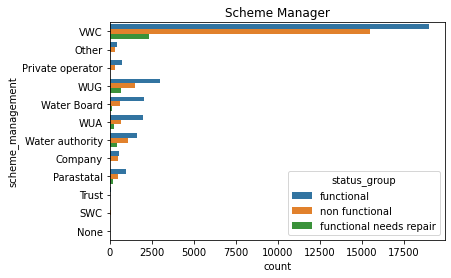

In [45]:
sns.countplot(data=df, y='scheme_management', hue='status_group', dodge=1.0)
plt.title('Scheme Manager')
plt.show()

Observations :
- **3877** rows of NaN data.
- Data is relatively clean.
- scheme_management may not have a scheme_name for each water well altough operated by the same provider

Suggestions :
- Perform data imputation on scheme_management through multivariate chained imputation.
- Use scheme_management and drop **scheme_name** if required.

### 1.1.7 Permit

In [47]:
df['permit'].unique()

array([False, True, nan], dtype=object)

In [48]:
df['permit'].isna().sum()

3056

In [49]:
df['permit'].value_counts()

True     38852
False    17492
Name: permit, dtype: int64

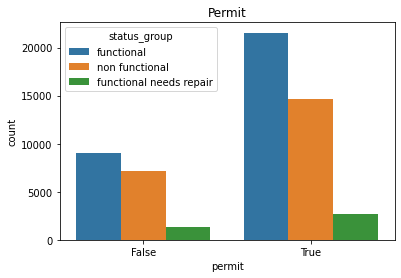

In [51]:
sns.countplot(data=df, x='permit', hue='status_group', dodge=1.0)
plt.title('Permit')
plt.show()

Observations :
- **3056** rows of NaN data.
- Two categories only : True or False

Suggestions :
- Could be dropped if not important.

### 1.1.8 Construction Year

In [54]:
df.sort_values(by='construction_year', inplace=True)
df['construction_year'].unique()

array([   0, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969,
       1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980,
       1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991,
       1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002,
       2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013])

In [55]:
df['construction_year'].value_counts()

0       20709
2010     2645
2008     2613
2009     2533
2000     2091
2007     1587
2006     1471
2003     1286
2011     1256
2004     1123
2012     1084
2002     1075
1978     1037
1995     1014
2005     1011
1999      979
1998      966
1990      954
1985      945
1980      811
1996      811
1984      779
1982      744
1994      738
1972      708
1974      676
1997      644
1992      640
1993      608
2001      540
1988      521
1983      488
1975      437
1986      434
1976      414
1970      411
1991      324
1989      316
1987      302
1981      238
1977      202
1979      192
1973      184
2013      176
1971      145
1960      102
1967       88
1963       85
1968       77
1969       59
1964       40
1962       30
1961       21
1965       19
1966       17
Name: construction_year, dtype: int64

Text(0, 0.5, 'No of Instances')

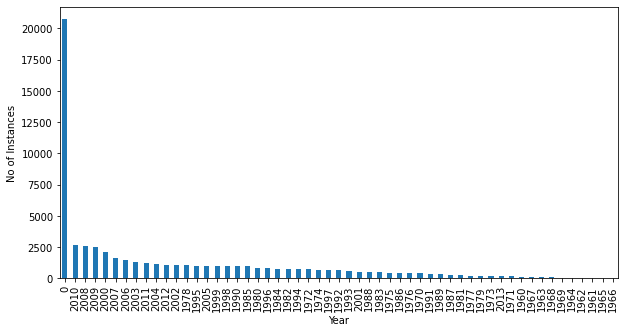

In [56]:
plt.figure(figsize=(10,5))
df['construction_year'].value_counts().plot(kind="bar")
plt.xlabel("Year")
plt.ylabel("No of Instances")

Observations :
- Approximately **40%** of rows has construction year of value **0**.

Suggestions :
- Perform data imputation.
- Remain as it is as last resort.

Because of the number of 0's, we took some extra time to check the correlation of `construction_year` to other features, to see if we could use those features to impute the 0 values.

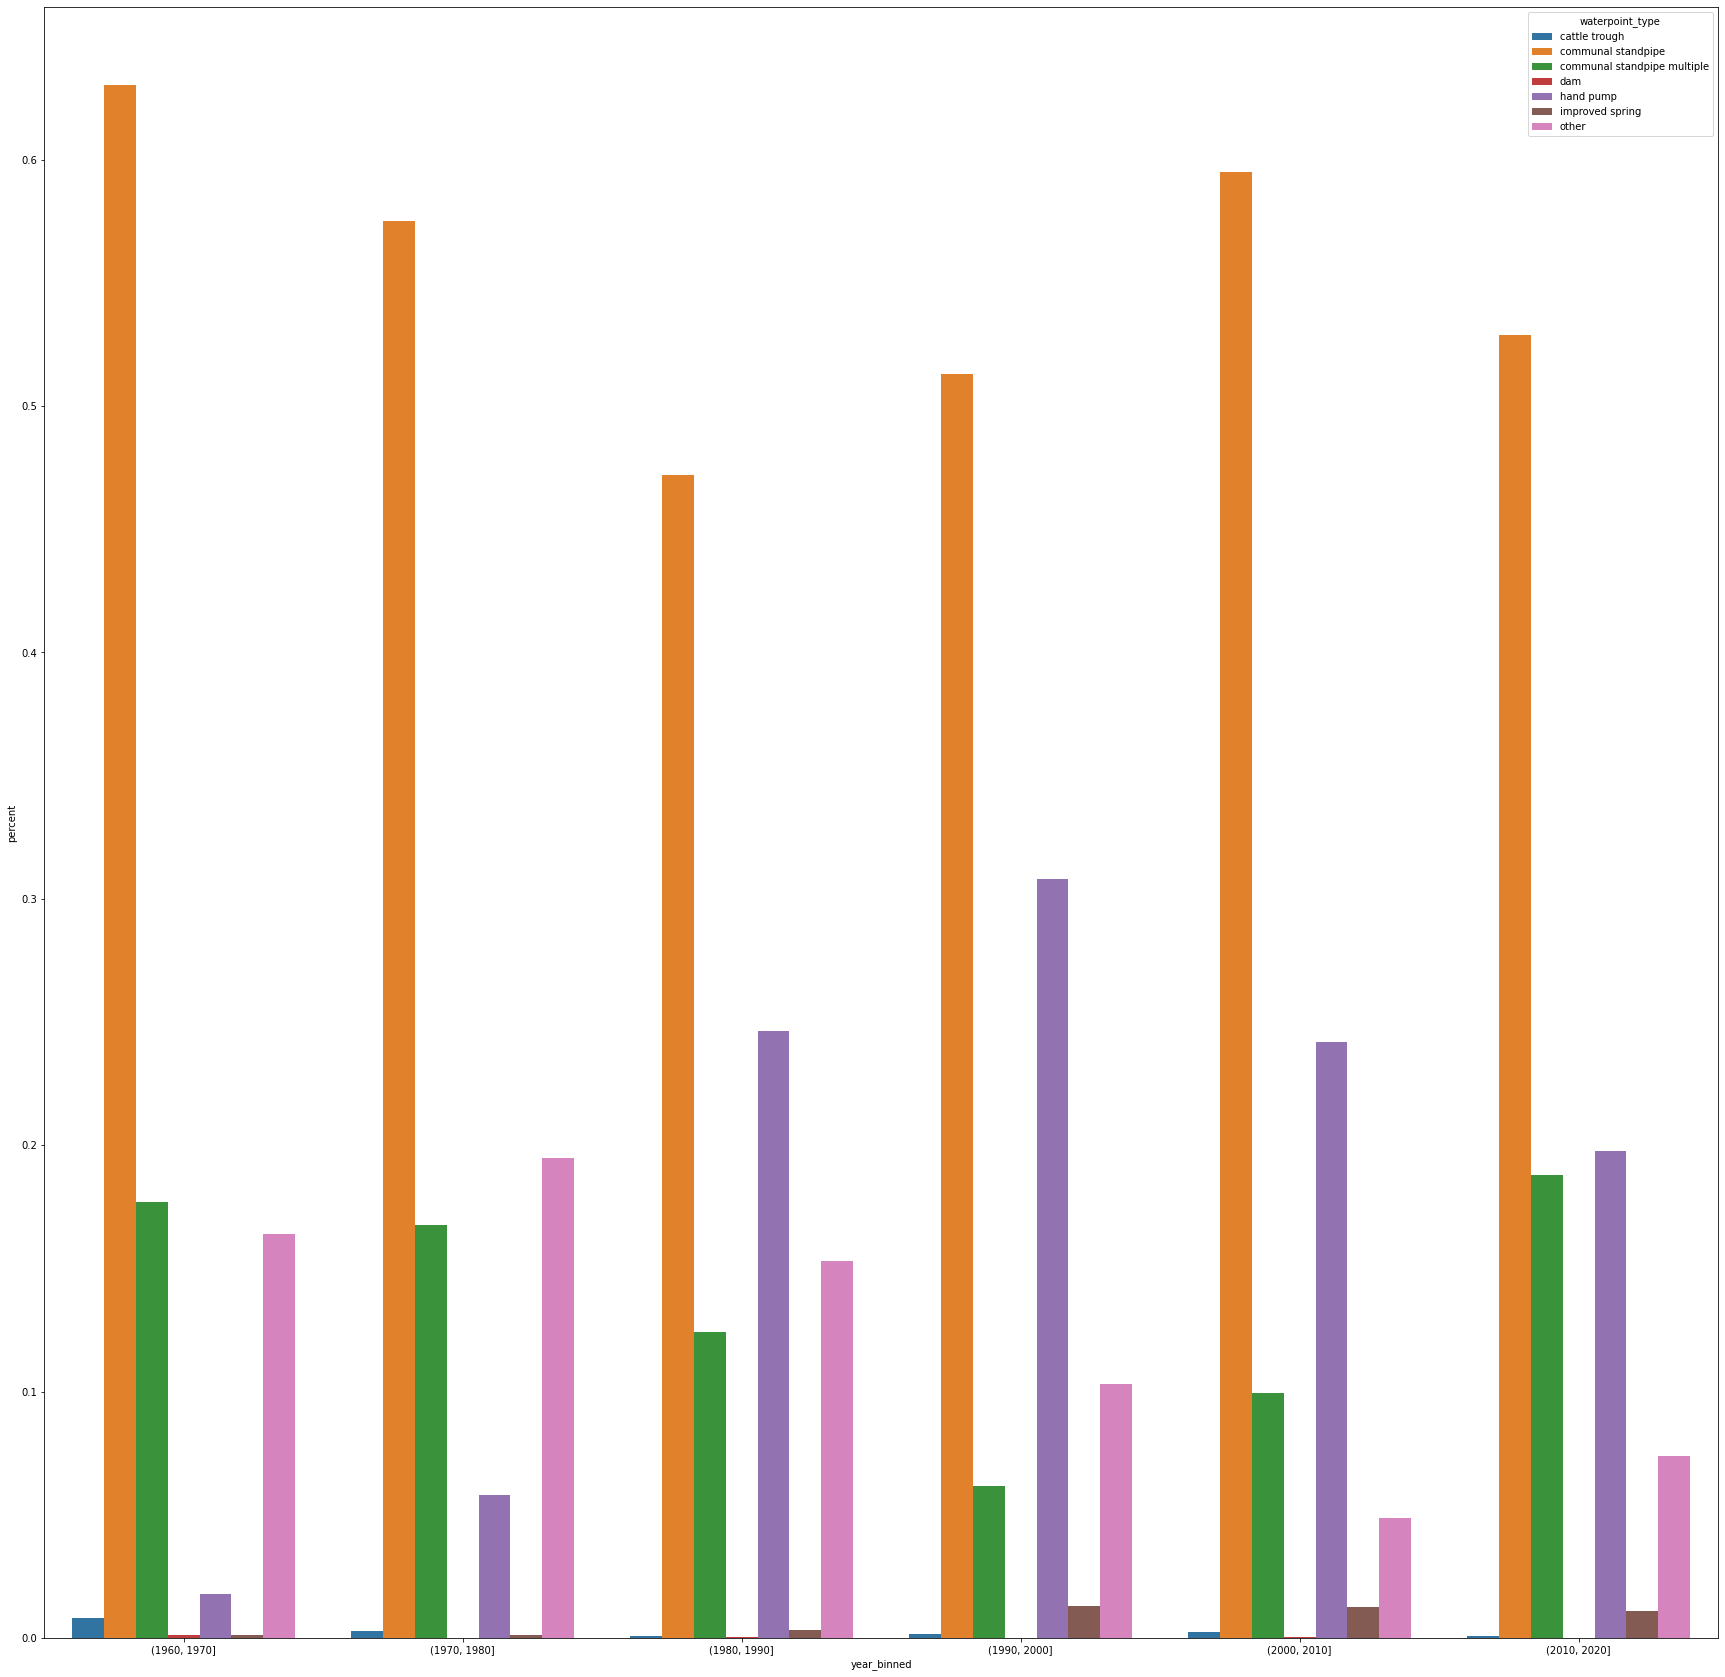

In [58]:
# Author [Tom]

# let's just drop the 0s for now

df_test = df.copy()
df_test = df_test[df_test['construction_year'] != 0]

bins = [1960, 1970, 1980, 1990, 2000, 2010, 2020]
df_test['year_binned'] = pd.cut(df['construction_year'], bins)

df_gby = df_test.groupby(['year_binned', 'waterpoint_type']).agg('size').reset_index(name='counts')
df_gby['percent'] = df_gby.groupby('year_binned')['counts'].transform(lambda x: x/sum(x))

fig, axs = plt.subplots(figsize=(30, 30))
sns.barplot(data=df_gby, x="year_binned", y='percent', hue='waterpoint_type')
plt.show()

There doesn't seem to be much correlation between the waterpoint_type and construction year. There are two points:

    - 'other' usage goes down as time progresses
    - 'hand pump' usage goes up as time progresses

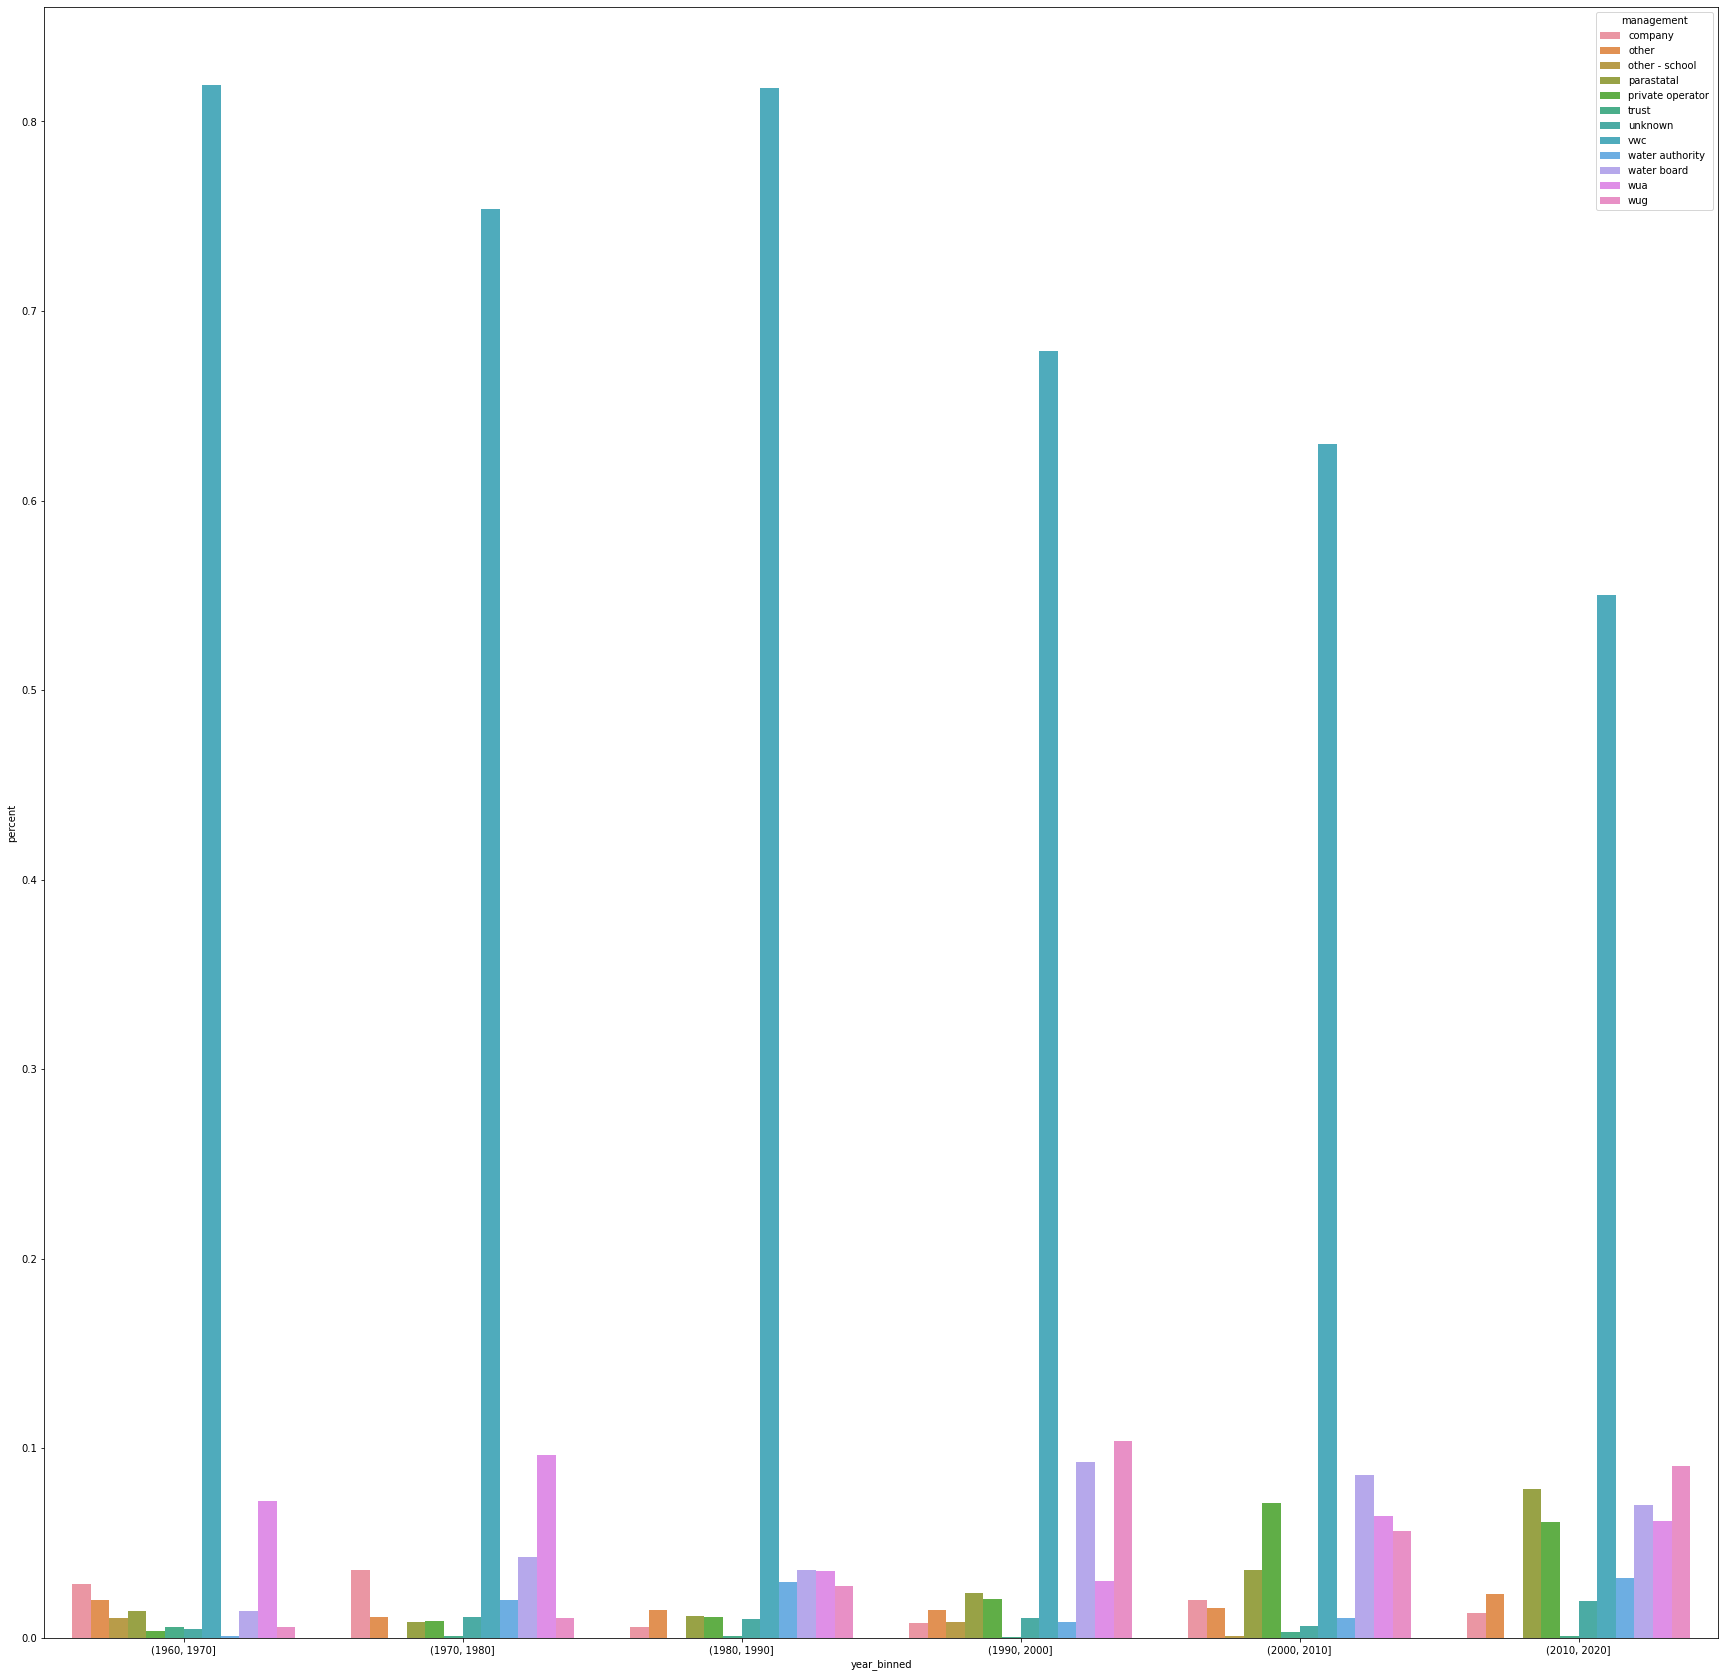

In [59]:
# Author [Tom]

df_gby = df_test.groupby(['year_binned', 'management']).agg('size').reset_index(name='counts')
df_gby['percent'] = df_gby.groupby('year_binned')['counts'].transform(lambda x: x/sum(x))

fig, axs = plt.subplots(figsize=(30, 30))
sns.barplot(data=df_gby, x="year_binned", y='percent', hue='management')
plt.show()

Interesting point here, 'parastatal' and 'private' definitely go up in percentage installed as the years increase.

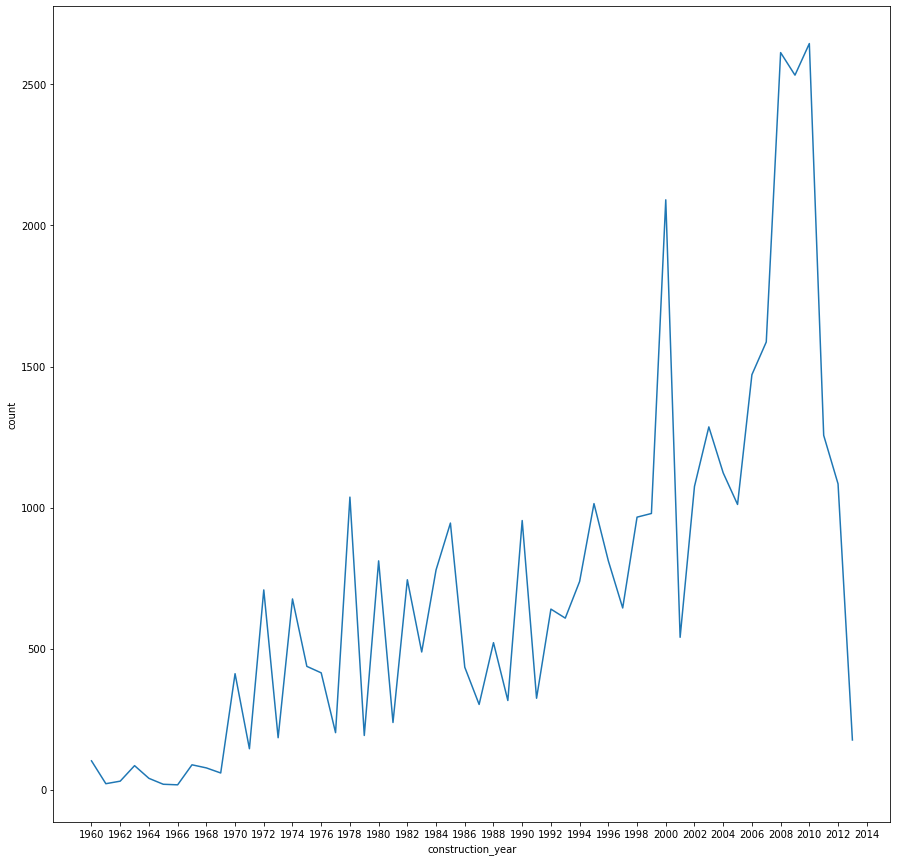

In [60]:
# Author [Tom]

df_years = df_test.groupby('construction_year').size().reset_index(name='count')
fig, ax = plt.subplots(figsize=(15, 15))

sns.lineplot(data=df_years, x='construction_year', y='count', ax=ax)
ax.xaxis.set_ticks(np.arange(1960, 2016, 2))
plt.show()

### 1.1.9 Extraction_Type / Extraction_Type_Group / Extraction_Type_Class

In [62]:
df.sort_values(by='extraction_type', inplace=True)
print(df['extraction_type'].unique())

df.sort_values(by='extraction_type_group', inplace=True)
print(df['extraction_type_group'].unique())

df.sort_values(by='extraction_type_class', inplace=True)
print(df['extraction_type_class'].unique())

['afridev' 'cemo' 'climax' 'gravity' 'india mark ii' 'india mark iii'
 'ksb' 'mono' 'nira/tanira' 'other' 'other - mkulima/shinyanga'
 'other - play pump' 'other - rope pump' 'other - swn 81' 'submersible'
 'swn 80' 'walimi' 'windmill']
['afridev' 'gravity' 'india mark ii' 'india mark iii' 'mono' 'nira/tanira'
 'other' 'other handpump' 'other motorpump' 'rope pump' 'submersible'
 'swn 80' 'wind-powered']
['gravity' 'handpump' 'motorpump' 'other' 'rope pump' 'submersible'
 'wind-powered']


In [64]:
df['extraction_type'].value_counts()

gravity                      26780
nira/tanira                   8154
other                         6430
submersible                   4764
swn 80                        3670
mono                          2865
india mark ii                 2400
afridev                       1770
ksb                           1415
other - rope pump              451
other - swn 81                 229
windmill                       117
india mark iii                  98
cemo                            90
other - play pump               85
walimi                          48
climax                          32
other - mkulima/shinyanga        2
Name: extraction_type, dtype: int64

In [65]:
df['extraction_type_group'].value_counts()

gravity            26780
nira/tanira         8154
other               6430
submersible         6179
swn 80              3670
mono                2865
india mark ii       2400
afridev             1770
rope pump            451
other handpump       364
other motorpump      122
wind-powered         117
india mark iii        98
Name: extraction_type_group, dtype: int64

In [66]:
df['extraction_type_class'].value_counts()

gravity         26780
handpump        16456
other            6430
submersible      6179
motorpump        2987
rope pump         451
wind-powered      117
Name: extraction_type_class, dtype: int64

In [68]:
print(len(df['extraction_type'].unique()))

print(len(df['extraction_type_group'].unique()))

print(len(df['extraction_type_class'].unique()))

18
13
7


Text(0.5, 1.0, 'Extraction Type Class')

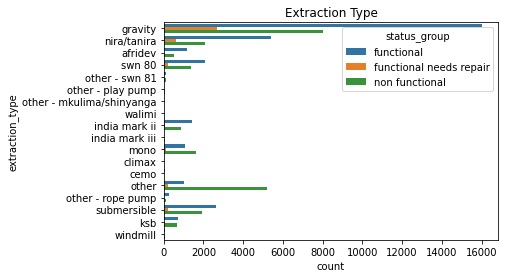

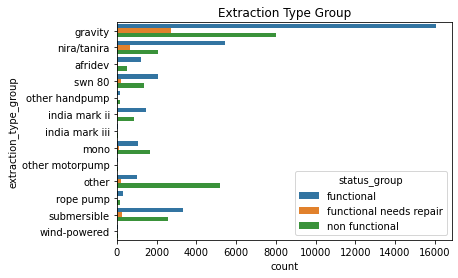

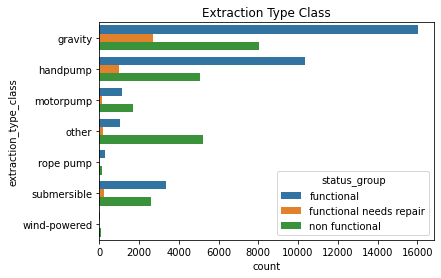

In [70]:
sns.countplot(data=df, y='extraction_type', hue='status_group', dodge=1.0)
plt.title('Extraction Type')

plt.figure()
sns.countplot(data=df, y='extraction_type_group', hue='status_group', dodge=1.0)
plt.title('Extraction Type Group')

plt.figure()
sns.countplot(data=df, y='extraction_type_class', hue='status_group', dodge=1.0)
plt.title('Extraction Type Class')

Observations :
- extraction_type has **18** categories.
- extraction_type_group has **13** categories.
- extraction_type_class has **7** categories.
- All 3 columns represent the extraction method the waterpoint uses.

Suggestions :
- Use **extraction_type_class** as it could represent the dataset in least number of categories.
- Drop **extraction_type** and **extraction_type_group**.

### 1.1.10 Management / Management Group

In [72]:
df.sort_values(by='management', inplace=True)
print(df['management'].unique())

df.sort_values(by='management_group', inplace=True)
print(df['management'].unique())

['company' 'other' 'other - school' 'parastatal' 'private operator'
 'trust' 'unknown' 'vwc' 'water authority' 'water board' 'wua' 'wug']
['company' 'private operator' 'water authority' 'trust' 'other'
 'other - school' 'parastatal' 'unknown' 'vwc' 'water board' 'wug' 'wua']


In [74]:
df['management'].value_counts()

vwc                 40507
wug                  6515
water board          2933
wua                  2535
private operator     1971
parastatal           1768
water authority       904
other                 844
company               685
unknown               561
other - school         99
trust                  78
Name: management, dtype: int64

In [75]:
df['management_group'].value_counts()

user-group    52490
commercial     3638
parastatal     1768
other           943
unknown         561
Name: management_group, dtype: int64

In [77]:
print(len(df['management'].unique()))

print(len(df['management_group'].unique()))

12
5


Text(0.5, 1.0, 'Management Group')

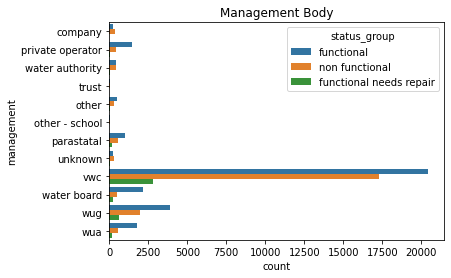

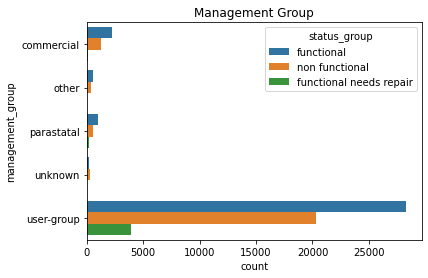

In [78]:
sns.countplot(data=df, y='management', hue='status_group', dodge=1.0)
plt.title('Management Body')

plt.figure()
sns.countplot(data=df, y='management_group', hue='status_group', dodge=1.0)
plt.title('Management Group')

Observations :
- extraction_type has **12** categories.
- extraction_type_group has **5** categories.
- Both columns represent the management of waterpoint.

Suggestions :
- Use management_group column and drop management column.

### 1.1.11 Payment / Payment_Type

In [80]:
df.sort_values(by='payment', inplace=True)
print(df['payment'].unique())

df.sort_values(by='payment_type', inplace=True)
print(df['payment_type'].unique())

['never pay' 'other' 'pay annually' 'pay monthly' 'pay per bucket'
 'pay when scheme fails' 'unknown']
['annually' 'monthly' 'never pay' 'on failure' 'other' 'per bucket'
 'unknown']


In [81]:
df['payment'].value_counts()

never pay                25348
pay per bucket            8985
pay monthly               8300
unknown                   8157
pay when scheme fails     3914
pay annually              3642
other                     1054
Name: payment, dtype: int64

In [82]:
df['payment_type'].value_counts()

never pay     25348
per bucket     8985
monthly        8300
unknown        8157
on failure     3914
annually       3642
other          1054
Name: payment_type, dtype: int64

In [84]:
print(len(df['payment'].unique()))

print(len(df['payment_type'].unique()))

7
7


Text(0.5, 1.0, 'Payment Type')

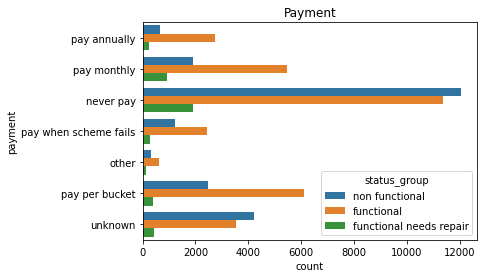

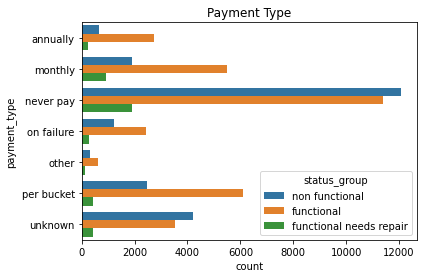

In [85]:
sns.countplot(data=df, y='payment', hue='status_group', dodge=1.0)
plt.title('Payment')

plt.figure()
sns.countplot(data=df, y='payment_type', hue='status_group', dodge=1.0)
plt.title('Payment Type')

Observations :
- Both **payment** and **payment_type** columns represent the same values.
- Both columns have the same number of classess at **7**.

Suggestions :
- Select either one and drop the other. (if applicable)

### 1.1.12 Water_Quality / Quality_Group

In [86]:
df.sort_values(by='water_quality', inplace=True)
print(df['water_quality'].unique())

df.sort_values(by='quality_group', inplace=True)
print(df['quality_group'].unique())

['coloured' 'fluoride' 'fluoride abandoned' 'milky' 'salty'
 'salty abandoned' 'soft' 'unknown']
['colored' 'fluoride' 'good' 'milky' 'salty' 'unknown']


In [87]:
df['water_quality'].value_counts()

soft                  50818
salty                  4856
unknown                1876
milky                   804
coloured                490
salty abandoned         339
fluoride                200
fluoride abandoned       17
Name: water_quality, dtype: int64

In [88]:
df['quality_group'].value_counts()

good        50818
salty        5195
unknown      1876
milky         804
colored       490
fluoride      217
Name: quality_group, dtype: int64

In [90]:
print(len(df['water_quality'].unique()))

print(len(df['quality_group'].unique()))

8
6


Text(0.5, 1.0, 'Quality Group')

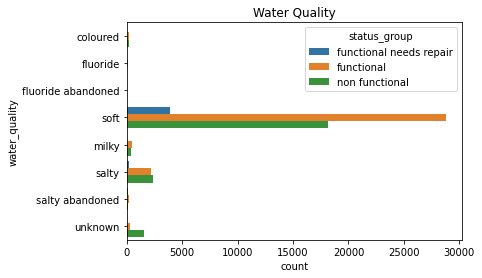

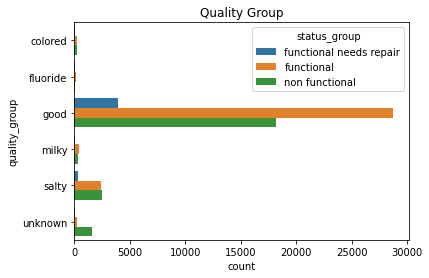

In [91]:
sns.countplot(data=df, y='water_quality', hue='status_group', dodge=1.0)
plt.title('Water Quality')

plt.figure()
sns.countplot(data=df, y='quality_group', hue='status_group', dodge=1.0)
plt.title('Quality Group')

Observations :
- water_quality has 8 categories while quality_group has 6 categories.

Suggestions :
- At first glance, might be advisable to use **water_quality** instead of **quality_group** as it is possible for water_quality to be abandoned but functional. (**To be reviewed during modelling stage**).

### 1.1.13 Quantity / Quantity_Group

In [93]:
df.sort_values(by='quantity', inplace=True)
print(df['quantity'].unique())

df.sort_values(by='quantity_group', inplace=True)
print(df['quantity_group'].unique())

['dry' 'enough' 'insufficient' 'seasonal' 'unknown']
['dry' 'enough' 'insufficient' 'seasonal' 'unknown']


In [95]:
df['quantity'].value_counts()

enough          33186
insufficient    15129
dry              6246
seasonal         4050
unknown           789
Name: quantity, dtype: int64

In [96]:
df['quantity_group'].value_counts()

enough          33186
insufficient    15129
dry              6246
seasonal         4050
unknown           789
Name: quantity_group, dtype: int64

In [97]:
print(len(df['quantity'].unique()))

print(len(df['quantity_group'].unique()))

5
5


Text(0.5, 1.0, 'Quantity Group')

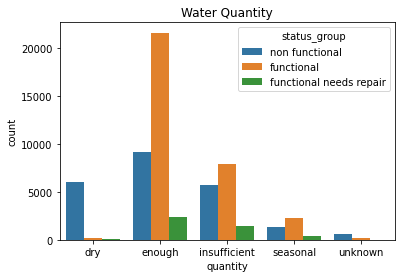

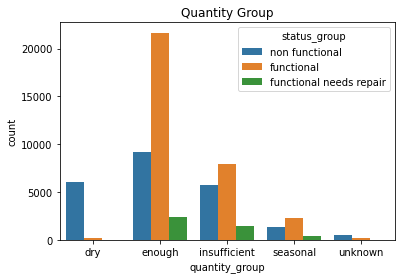

In [98]:
sns.countplot(data=df, x='quantity', hue='status_group', dodge=1.0)
plt.title('Water Quantity')

plt.figure()
sns.countplot(data=df, x='quantity_group', hue='status_group', dodge=1.0)
plt.title('Quantity Group')

Observations :
- Both **quantity** and **quantity_group** columns represent the same values.
- Both columns have the same number of classess at **5**.

Suggestions :
- Select either one and drop the other. (if applicable)

### 1.1.14 Source / Source_Type / Source_Class

In [100]:
df.sort_values(by='source', inplace=True)
print(df['source'].unique())

df.sort_values(by='source_type', inplace=True)
print(df['source_type'].unique())

df.sort_values(by='source_class', inplace=True)
print(df['source_class'].unique())

['dam' 'hand dtw' 'lake' 'machine dbh' 'other' 'rainwater harvesting'
 'river' 'shallow well' 'spring' 'unknown']
['borehole' 'dam' 'other' 'rainwater harvesting' 'river/lake'
 'shallow well' 'spring']
['groundwater' 'surface' 'unknown']


In [101]:
df['source'].value_counts()

spring                  17021
shallow well            16824
machine dbh             11075
river                    9612
rainwater harvesting     2295
hand dtw                  874
lake                      765
dam                       656
other                     212
unknown                    66
Name: source, dtype: int64

In [102]:
df['source_type'].value_counts()

spring                  17021
shallow well            16824
borehole                11949
river/lake              10377
rainwater harvesting     2295
dam                       656
other                     278
Name: source_type, dtype: int64

In [103]:
df['source_class'].value_counts()

groundwater    45794
surface        13328
unknown          278
Name: source_class, dtype: int64

In [104]:
print(len(df['source'].unique()))

print(len(df['source_type'].unique()))

print(len(df['source_class'].unique()))

10
7
3


Text(0.5, 1.0, 'Source Class')

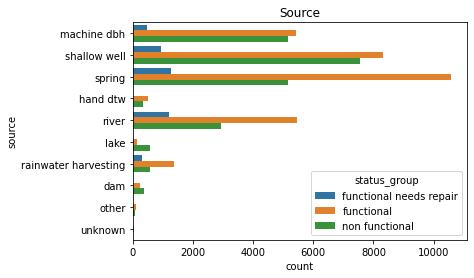

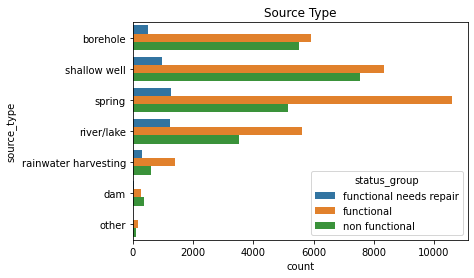

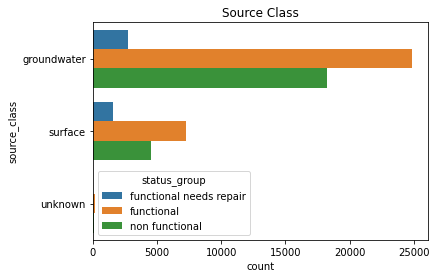

In [105]:
sns.countplot(data=df, y='source', hue='status_group', dodge=1.0)
plt.title('Source')

plt.figure()
sns.countplot(data=df, y='source_type', hue='status_group', dodge=1.0)
plt.title('Source Type')

plt.figure()
sns.countplot(data=df, y='source_class', hue='status_group', dodge=1.0)
plt.title('Source Class')

Observations :
- Certain values in **source_type** can represent values in **source** column without the need of new categories.
- **source_class** column's data that is too abstract.

Suggestions :
- Use **source_type** instead of the other 2 columns.

### 1.1.15 Waterpoint_Type / Waterpoint_Type_Group

In [106]:
df.sort_values(by='waterpoint_type', inplace=True)
df['waterpoint_type'].unique()

df.sort_values(by='waterpoint_type_group', inplace=True)
df['waterpoint_type_group'].unique()

array(['cattle trough', 'communal standpipe', 'dam', 'hand pump',
       'improved spring', 'other'], dtype=object)

In [107]:
df['waterpoint_type'].value_counts()

communal standpipe             28522
hand pump                      17488
other                           6380
communal standpipe multiple     6103
improved spring                  784
cattle trough                    116
dam                                7
Name: waterpoint_type, dtype: int64

In [108]:
df['waterpoint_type_group'].value_counts()

communal standpipe    34625
hand pump             17488
other                  6380
improved spring         784
cattle trough           116
dam                       7
Name: waterpoint_type_group, dtype: int64

In [109]:
print(len(df['waterpoint_type'].unique()))

print(len(df['waterpoint_type_group'].unique()))

7
6


Text(0.5, 1.0, 'Waterpoint Type Group')

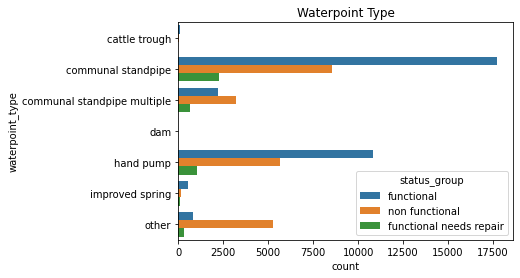

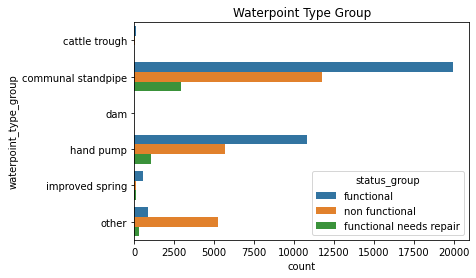

In [110]:
sns.countplot(data=df, y='waterpoint_type', hue='status_group', dodge=1.0)
plt.title('Waterpoint Type')

plt.figure()
sns.countplot(data=df, y='waterpoint_type_group', hue='status_group', dodge=1.0)
plt.title('Waterpoint Type Group')

Observations :
- Communal Standpipe in waterpoint_type_group can represent communal standpipe multiple in **waterpoint_type** column.

Suggestions :
- Use **waterpoint_type_group** and drop the other . (If applicable)